In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns
from sqlalchemy import create_engine

%matplotlib inline
mat_c = {'g':'#4CAF50','r':'#FF9800','i':'#f44336','z':'#607D8B'}
index2type = {1:'Ia',  11:'Iax', 12: '91bg', 60: 'KN', 70: 'SLSN', 50: 'CART', 80:'TDE', 21: 'IIn' , 23: 'IIb' , 25 :'II', 32: 'Ib', 33 :'Ic', 35: 'Ic-BL', 20:'CC'}

In [2]:
##!! Change this to include your own credentials file
conf = yaml.load(open('/data/cf5g09/tides/tidesCredentials/dbLogin.yml'))

username = conf['tidesdb']['username']
pwd = conf['tidesdb']['password']
host = conf['tidesdb']['host']
port = conf['tidesdb']['port']
db_name = conf['tidesdb']['db_name']
engine = create_engine('postgresql+psycopg2://'+str(username)+':'+str(pwd)+'@'+str(host)+':'+str(port)+'/'+str(db_name))
conn = engine.raw_connection()
cur = conn.cursor()

In [55]:
def makeCadenceCosmoStats(snfit, specSN, title='Default Title', savename='gridCadence.pdf'):

    
    merged = specSN.merge(snfit, how='inner', left_on='snid', right_on='CID', suffixes=(False, False), copy=True)
    
    mergedCosmo = merged[(abs(merged['c'])<.3) & (abs(merged['x1'])<3)\
                         & (merged['FITPROB']>0.001) & (merged['x1ERR']<1) & (merged['PKMJDERR']<1)].copy()
    
    
    fig = plt.figure(figsize=(15,10))  
    fig.suptitle(title, size=14)
    gs = fig.add_gridspec(3, 3)
    
    f3_ax1 = fig.add_subplot(gs[0,0])
    plt.hist(merged['x1'], histtype='step', bins=np.arange(-4,4.2,0.2), label='All SNe Ia')
    plt.hist(mergedCosmo['x1'], histtype='step', bins=np.arange(-4,4.2,0.2), label='Cosmo-useful SNe Ia' )
    plt.xlabel('x1')
    plt.legend(loc='upper left')
    
    f3_ax1b = fig.add_subplot(gs[1,0])
    plt.hist(merged['x1ERR'], histtype='step', bins=np.arange(0,1,0.02), label='All SNe Ia')
    plt.hist(mergedCosmo['x1ERR'], histtype='step', bins=np.arange(0,1,0.02), label='Cosmo-useful SNe Ia' )
    plt.xlabel(r'$\sigma$ x1')
    
    
    f3_ax2 = fig.add_subplot(gs[0,1])
    plt.hist(merged['c'], histtype='step', bins=np.arange(-.4,.42,0.02))
    plt.hist(mergedCosmo['c'], histtype='step', bins=np.arange(-.4,.42,0.02))
    plt.xlabel('c')
    
    f3_ax2 = fig.add_subplot(gs[1,1])
    plt.hist(merged['cERR'], histtype='step', bins=np.arange(0,0.12,0.001))
    plt.hist(mergedCosmo['cERR'], histtype='step', bins=np.arange(0,0.12,0.001))
    plt.xlabel(r'$\sigma$ c')
    
    f3_ax3 = fig.add_subplot(gs[0,2])
    plt.hist(merged['mBERR'], histtype='step', bins=np.arange(0,0.2,0.01))
    plt.hist(mergedCosmo['mBERR'], histtype='step', bins=np.arange(0,0.2,0.01))
    plt.xlabel(r'$\sigma$m$_B$')
    
    f3_axZ = fig.add_subplot(gs[1,2])
    plt.hist(merged['zHD'], histtype='step', bins=np.arange(0,0.8,0.01), label = 'Total: '+str(len(merged['zHD'])))
    plt.hist(mergedCosmo['zHD'], histtype='step', bins=np.arange(0,0.8,0.01), label = 'Cosmo: '+str(len(mergedCosmo['zHD'])))
    plt.legend(loc='upper right')
    plt.xlabel('z')
    plt.xlim(0,1)
    
    f3_ax4 = fig.add_subplot(gs[2,:2])
    mergedCosmo['mu'] = mergedCosmo['mB'] - (-19.365 - 0.141*mergedCosmo['x1'] + 3.1*mergedCosmo['c'])
    
    #mu_err = = ( mergedCosmo['mBERR']**2 + (0.141**2 * mergedCosmo['x1ERR']**2) + (3.1**2 * mergedCosmo['cERR']**2) + (2*0.141*cov_mBx1)  - (2*beta*cov_mBc) - (2*alpha*beta* cov_x1c) )**0.5
    sf = -2.5/(mergedCosmo['x0'] * np.log(10))
    
    mergedCosmo['muERR'] = ((mergedCosmo['mBERR'])**2 + (0.14*mergedCosmo['x1ERR'])**2 + (3.1*mergedCosmo['cERR'])**2 + 2*0.14*mergedCosmo['COV_x1_x0']*sf  - 2*3.1*mergedCosmo['COV_c_x0']*sf -2*0.14*3.1* mergedCosmo['COV_x1_c'] )**0.5
    
    mergedCosmo['sim_mu'] = mergedCosmo['SIM_mB'] - (-19.365 - 0.141*mergedCosmo['SIM_x1'] + 3.1*mergedCosmo['SIM_c'])
    plt.xlabel('z')
    plt.ylabel('$\mu$')
    plt.hexbin(mergedCosmo['zHD'], mergedCosmo['mu'], mincnt=1)
    cbar = plt.colorbar()
    cbar.set_label(r'\# of SNe in bin')
    
    f3_axZ = fig.add_subplot(gs[2,2])
    plt.hist(mergedCosmo['muERR'], histtype='step', bins=np.arange(0,0.41,0.005))
    #plt.legend(loc='upper right')
    plt.xlabel(r'$\sigma\mu$')
    #plt.xlim(0,1)
    plt.savefig(savename, bbox_inches='tight', dpi=300)
    #mergedCosmo['muERR'] = mu_err.values
    return mergedCosmo

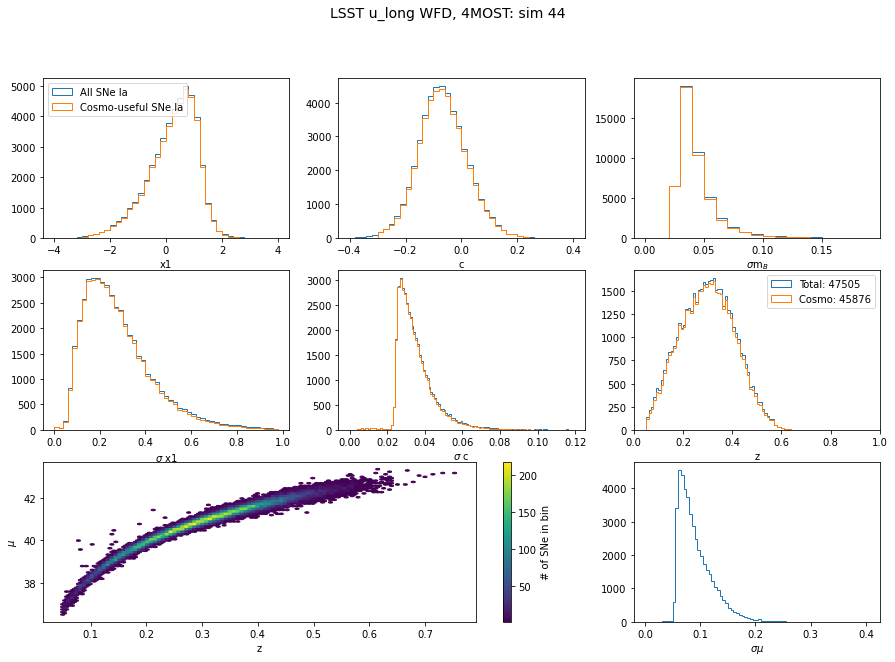

In [4]:
snfit = pd.read_csv('./SALT2FITS/ALL/output_WFD/MV_LSSTWFDUL_SNIa-SALT2/FITOPT000.FITRES', delimiter='\s+', comment='#')
snfit['CID'] = snfit['CID'].astype(int)

specSN = pd.read_csv('/data/cf5g09/tides/paperSims2021/Jan2021/catalogues4FS/cadenceNoteOutputs/u_long_1pt7_wfd_liveQueue_44_nov2020_cadenceNote_IndexQ.csv')
specSN['snid'] = specSN['snid'].astype(int)

ulong_Merged = makeCadenceCosmoStats(snfit, specSN, title = 'LSST u_long WFD, 4MOST: sim 44', savename='ulong_WFD_4most_44.pdf')

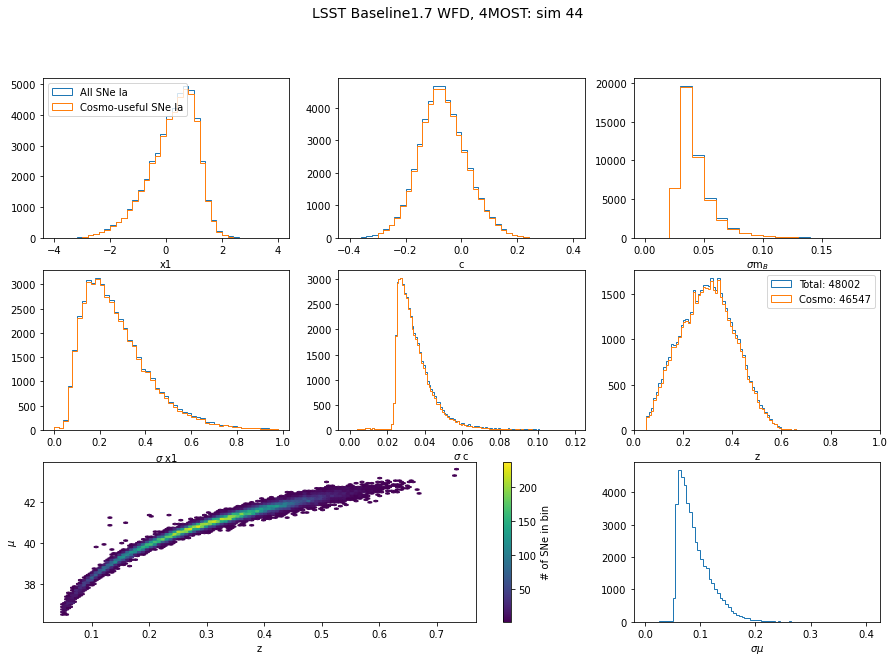

In [5]:
snfit = pd.read_csv('./SALT2FITS/ALL/output_WFD/MV_LSSTWFD17_SNIa-SALT2/FITOPT000.FITRES', delimiter='\s+', comment='#')
snfit['CID'] = snfit['CID'].astype(int)

specSN = pd.read_csv('/data/cf5g09/tides/paperSims2021/Jan2021/catalogues4FS/cadenceNoteOutputs/baseline_1pt7_wfd_liveQueue_44_nov2020_cadenceNote_IndexQ.csv')
specSN['snid'] = specSN['snid'].astype(int)
baseline1pt7_merged = makeCadenceCosmoStats(snfit, specSN, title = 'LSST Baseline1.7 WFD, 4MOST: sim 44', savename='baseline1pt7_WFD_4most_44.pdf')

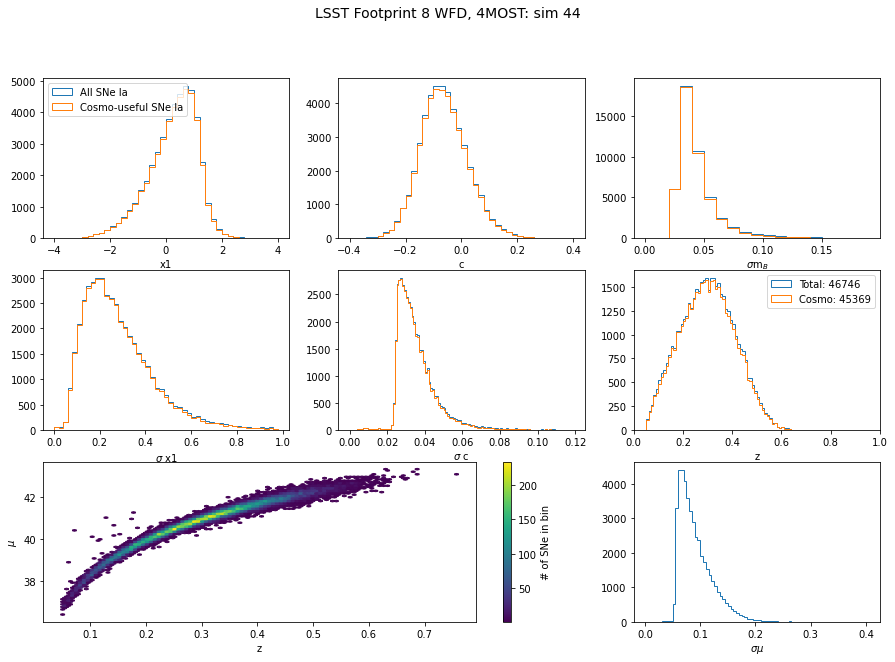

In [6]:
snfit = pd.read_csv('./SALT2FITS/ALL/output_WFD/MV_LSSTWFDF8_SNIa-SALT2/FITOPT000.FITRES', delimiter='\s+', comment='#')
snfit['CID'] = snfit['CID'].astype(int)

specSN = pd.read_csv('/data/cf5g09/tides/paperSims2021/Jan2021/catalogues4FS/cadenceNoteOutputs/footprint8_1pt7_wfd_liveQueue_44_nov2020_cadenceNote_IndexQ.csv')
specSN['snid'] = specSN['snid'].astype(int)
footprint8_Merged = makeCadenceCosmoStats(snfit, specSN, title = 'LSST Footprint 8 WFD, 4MOST: sim 44', savename='footprint8_WFD_4most_44.pdf')

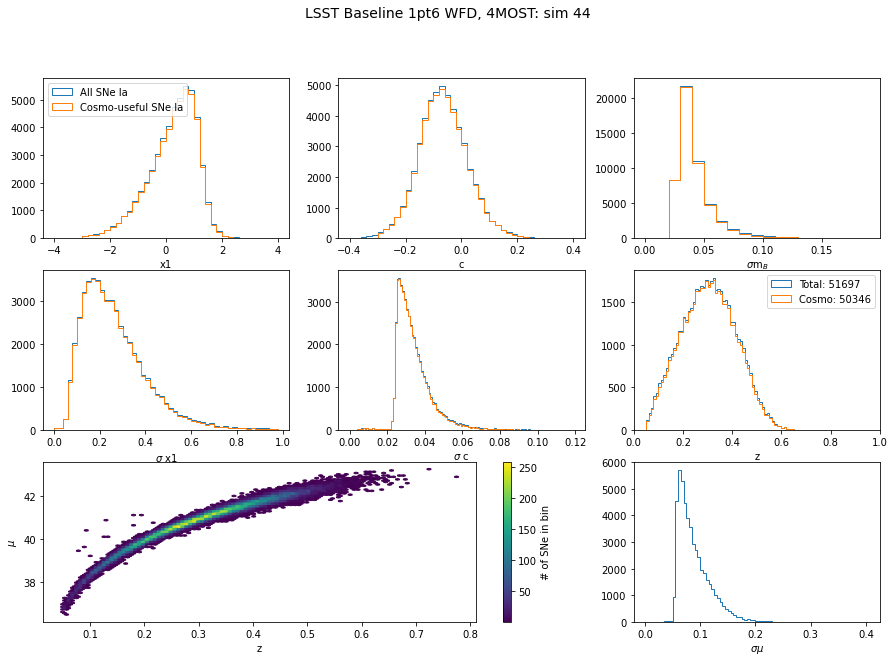

In [7]:
snfit = pd.read_csv('./SALT2FITS/ALL/output_WFD/MV_LSSTWFD_SNIa-SALT2/FITOPT000.FITRES', delimiter='\s+', comment='#')
snfit['CID'] = snfit['CID'].astype(int)

specSN = pd.read_csv('/data/cf5g09/tides/paperSims2021/Jan2021/catalogues4FS/cadenceNoteOutputs/baseline16_1pt7_wfd_liveQueue_44_nov2020_cadenceNote_IndexQ.csv')
specSN['snid'] = specSN['snid'].astype(int)
baseline1pt6_Merged = makeCadenceCosmoStats(snfit, specSN, title = 'LSST Baseline 1pt6 WFD, 4MOST: sim 44', savename='baseline1pt6_WFD_4most_44.pdf')

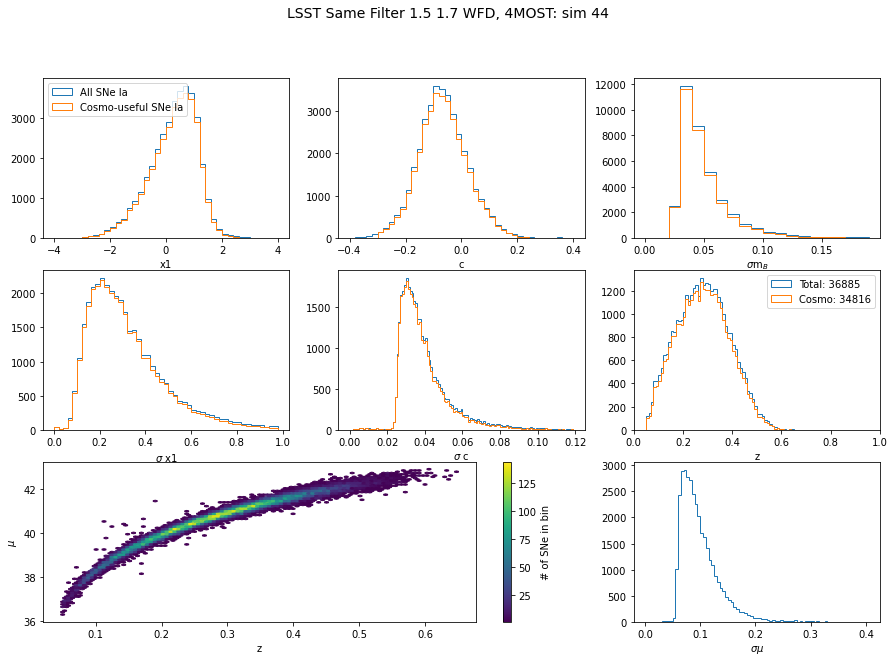

In [8]:
snfit = pd.read_csv('./SALT2FITS/ALL/output_sameflt/MV_LSSTWFDSF_SNIa-SALT2/FITOPT000.FITRES.gz', delimiter='\s+', comment='#')
snfit['CID'] = snfit['CID'].astype(int)

specSN = pd.read_csv('/data/cf5g09/tides/paperSims2021/Jan2021/catalogues4FS/cadenceNoteOutputs/sameflt15_1pt7_wfd_liveQueue_44_nov2020_cadenceNote_IndexQ.csv')
specSN['snid'] = specSN['snid'].astype(int)
sameflt1pt7_Merged = makeCadenceCosmoStats(snfit, specSN, title = 'LSST Same Filter 1.5 1.7 WFD, 4MOST: sim 44', savename='sameflt1pt7_WFD_4most_44.pdf')

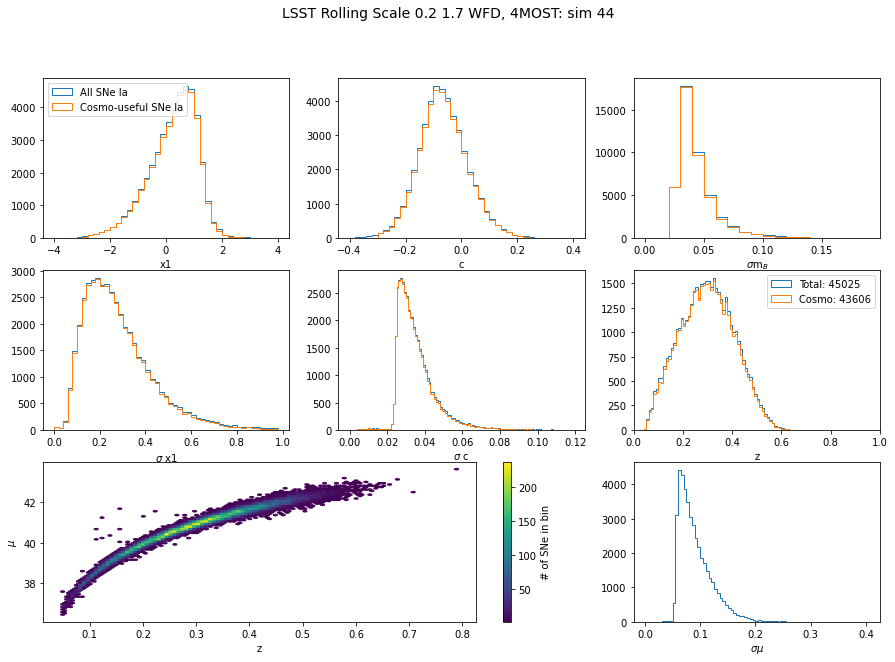

In [9]:
snfit = pd.read_csv('./SALT2FITS/ALL/output_WFD/MV_LSSTWFDR2_SNIa-SALT2/FITOPT000.FITRES', delimiter='\s+', comment='#')
snfit['CID'] = snfit['CID'].astype(int)

specSN = pd.read_csv('/data/cf5g09/tides/paperSims2021/March2021/liveSNeIa/rollingscale02_1pt7_wfd_liveQueue_44_nov2020_cadenceNote_IndexQ.csv')
specSN['snid'] = specSN['snid'].astype(int)
rolling02_Merged = makeCadenceCosmoStats(snfit, specSN, title = 'LSST Rolling Scale 0.2 1.7 WFD, 4MOST: sim 44', savename='rolling021pt7_WFD_4most_44.pdf')

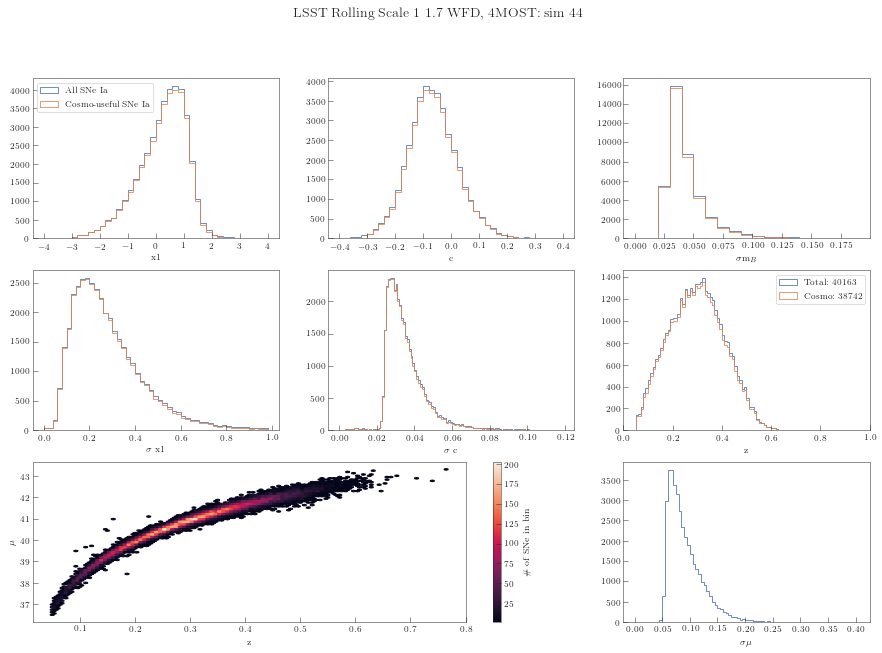

In [57]:
snfit = pd.read_csv('./SALT2FITS/ALL/output_WFD/MV_LSSTWFDR1_SNIa-SALT2/FITOPT000.FITRES.gz', delimiter='\s+', comment='#')
snfit['CID'] = snfit['CID'].astype(int)

specSN = pd.read_csv('/data/cf5g09/tides/paperSims2021/March2021/liveSNeIa/rollingscale1_1pt7_wfd_liveQueue_44_nov2020_cadenceNote_IndexQ.csv')
specSN['snid'] = specSN['snid'].astype(int)
rolling1_Merged = makeCadenceCosmoStats(snfit, specSN, title = 'LSST Rolling Scale 1 1.7 WFD, 4MOST: sim 44', savename='rolling021pt7_WFD_4most_44.pdf')

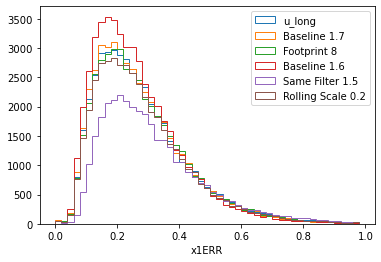

In [10]:
n, bins, patch = plt.hist(ulong_Merged['x1ERR'], label='u_long', histtype='step', bins = np.arange(0,1,0.02))
plt.hist(baseline1pt7_merged['x1ERR'], label='Baseline 1.7', histtype='step', bins = bins)
plt.hist(footprint8_Merged['x1ERR'], label='Footprint 8', histtype='step', bins = bins)
plt.hist(baseline1pt6_Merged['x1ERR'], label='Baseline 1.6', histtype='step', bins = bins)
plt.hist(sameflt1pt7_Merged['x1ERR'], label='Same Filter 1.5', histtype='step', bins = bins)
plt.hist(rolling02_Merged['x1ERR'], label='Rolling Scale 0.2', histtype='step', bins = bins)

plt.xlabel('x1ERR')
plt.legend()
plt.savefig('x1ERR_dist.pdf', bbox_inches='tight', dpi=300)

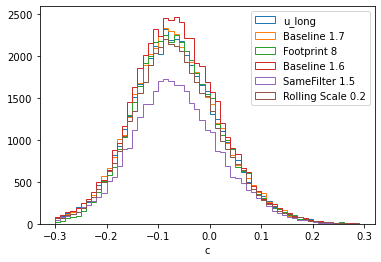

In [11]:
n, bins, patch = plt.hist(ulong_Merged['c'], label='u_long', histtype='step', bins = np.arange(-0.3,0.3,0.01))
plt.hist(baseline1pt7_merged['c'], label='Baseline 1.7', histtype='step', bins = bins)
plt.hist(footprint8_Merged['c'], label='Footprint 8', histtype='step', bins = bins)
plt.hist(baseline1pt6_Merged['c'], label='Baseline 1.6', histtype='step', bins = bins)
plt.hist(sameflt1pt7_Merged['c'], label='SameFilter 1.5', histtype='step', bins = bins)
plt.hist(rolling02_Merged['c'], label='Rolling Scale 0.2', histtype='step', bins = bins)

plt.xlabel('c')
plt.legend()
plt.savefig('C_dist.pdf', bbox_inches='tight', dpi=300)

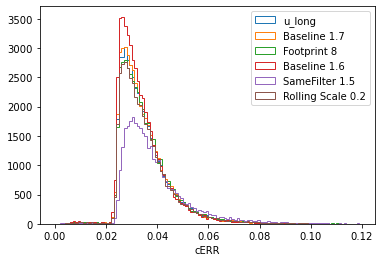

In [12]:
n, bins, patch = plt.hist(ulong_Merged['cERR'], label='u_long', histtype='step', bins = np.arange(0,0.12,0.001))
plt.hist(baseline1pt7_merged['cERR'], label='Baseline 1.7', histtype='step', bins = bins)
plt.hist(footprint8_Merged['cERR'], label='Footprint 8', histtype='step', bins = bins)
plt.hist(baseline1pt6_Merged['cERR'], label='Baseline 1.6', histtype='step', bins = bins)
plt.hist(sameflt1pt7_Merged['cERR'], label='SameFilter 1.5', histtype='step', bins = bins)
plt.hist(rolling02_Merged['cERR'], label='Rolling Scale 0.2', histtype='step', bins = bins)

plt.xlabel('cERR')
plt.legend()
plt.savefig('cERR_dist.pdf', bbox_inches='tight', dpi=300)

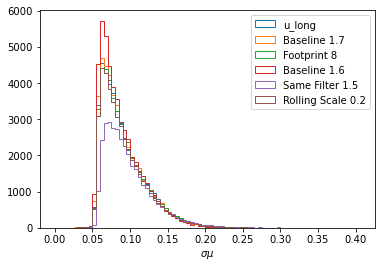

In [13]:
n, bins, patch = plt.hist(ulong_Merged['muERR'], label='u_long', histtype='step', bins = np.arange(0,0.41,0.005))
plt.hist(baseline1pt7_merged['muERR'], label='Baseline 1.7', histtype='step', bins = bins)
plt.hist(footprint8_Merged['muERR'], label='Footprint 8', histtype='step', bins = bins)
plt.hist(baseline1pt6_Merged['muERR'], label='Baseline 1.6', histtype='step', bins = bins)
plt.hist(sameflt1pt7_Merged['muERR'], label='Same Filter 1.5', histtype='step', bins = bins)
plt.hist(rolling02_Merged['muERR'], label='Rolling Scale 0.2', histtype='step', bins = bins)

plt.xlabel(r'$\sigma\mu$')
plt.legend()
plt.savefig('muERR_dist.pdf', bbox_inches='tight', dpi=300)

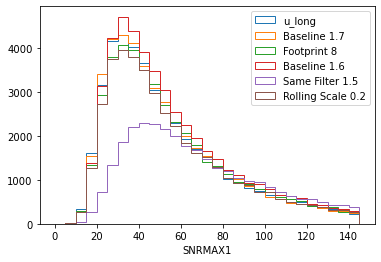

In [14]:
n, bins, patch = plt.hist(ulong_Merged['SNRMAX1'], label='u_long', histtype='step', bins = np.arange(0,150,5))
plt.hist(baseline1pt7_merged['SNRMAX1'], label='Baseline 1.7', histtype='step', bins = bins)
plt.hist(footprint8_Merged['SNRMAX1'], label='Footprint 8', histtype='step', bins = bins)
plt.hist(baseline1pt6_Merged['SNRMAX1'], label='Baseline 1.6', histtype='step', bins = bins)
plt.hist(sameflt1pt7_Merged['SNRMAX1'], label='Same Filter 1.5', histtype='step', bins = bins)
plt.hist(rolling02_Merged['SNRMAX1'], label='Rolling Scale 0.2', histtype='step', bins = bins)

plt.xlabel(r'SNRMAX1')
plt.legend()
plt.savefig('SNRMAX1_dist.pdf', bbox_inches='tight', dpi=300)

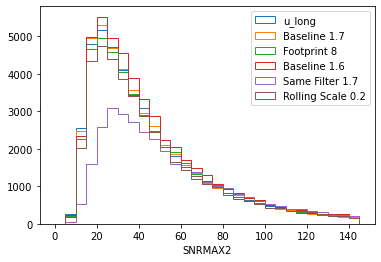

In [15]:
n, bins, patch = plt.hist(ulong_Merged['SNRMAX2'], label='u_long', histtype='step', bins = np.arange(0,150,5))
plt.hist(baseline1pt7_merged['SNRMAX2'], label='Baseline 1.7', histtype='step', bins = bins)
plt.hist(footprint8_Merged['SNRMAX2'], label='Footprint 8', histtype='step', bins = bins)
plt.hist(baseline1pt6_Merged['SNRMAX2'], label='Baseline 1.6', histtype='step', bins = bins)
plt.hist(sameflt1pt7_Merged['SNRMAX2'], label='Same Filter 1.7', histtype='step', bins = bins)
plt.hist(rolling02_Merged['SNRMAX2'], label='Rolling Scale 0.2', histtype='step', bins = bins)

plt.xlabel(r'SNRMAX2')
plt.legend()
plt.savefig('SNRMAX2_dist.pdf', bbox_inches='tight', dpi=300)

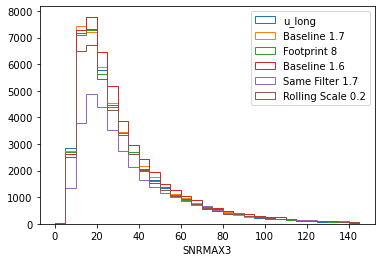

In [16]:
n, bins, patch = plt.hist(ulong_Merged['SNRMAX3'], label='u_long', histtype='step', bins = np.arange(0,150,5))
plt.hist(baseline1pt7_merged['SNRMAX3'], label='Baseline 1.7', histtype='step', bins = bins)
plt.hist(footprint8_Merged['SNRMAX3'], label='Footprint 8', histtype='step', bins = bins)
plt.hist(baseline1pt6_Merged['SNRMAX3'], label='Baseline 1.6', histtype='step', bins = bins)
plt.hist(sameflt1pt7_Merged['SNRMAX3'], label='Same Filter 1.7', histtype='step', bins = bins)
plt.hist(rolling02_Merged['SNRMAX3'], label='Rolling Scale 0.2', histtype='step', bins = bins)

plt.xlabel(r'SNRMAX3')
plt.legend()
plt.savefig('SNRMAX3_dist.pdf', bbox_inches='tight', dpi=300)

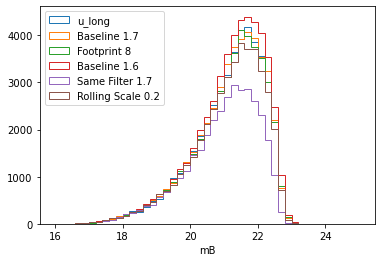

In [17]:
n, bins, patch = plt.hist(ulong_Merged['mB'], label='u_long', histtype='step', bins = np.arange(16,25.2,0.2))
plt.hist(baseline1pt7_merged['mB'], label='Baseline 1.7', histtype='step', bins = bins)
plt.hist(footprint8_Merged['mB'], label='Footprint 8', histtype='step', bins = bins)
plt.hist(baseline1pt6_Merged['mB'], label='Baseline 1.6', histtype='step', bins = bins)
plt.hist(sameflt1pt7_Merged['mB'], label='Same Filter 1.7', histtype='step', bins = bins)
plt.hist(rolling02_Merged['mB'], label='Rolling Scale 0.2', histtype='step', bins = bins)

plt.xlabel(r'mB')
plt.legend(loc='upper left')
plt.savefig('mB_dist.pdf', bbox_inches='tight', dpi=300)

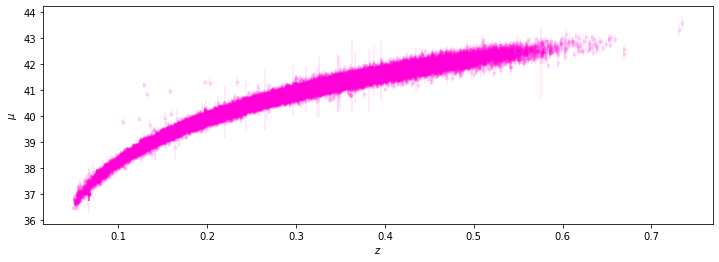

In [18]:
plt.figure(figsize=(12,4))
plt.errorbar(baseline1pt7_merged['zHD'], baseline1pt7_merged['mu'],\
             yerr=baseline1pt7_merged['muERR'], fmt='.', alpha=0.1,\
            color='#ff00d9')
plt.xlabel(r'$z$')
plt.ylabel(r'$\mu$')
plt.savefig('tidesBaseline1pt7_Hubble Diagram.png', dpi=300, bbox_inches='tight')

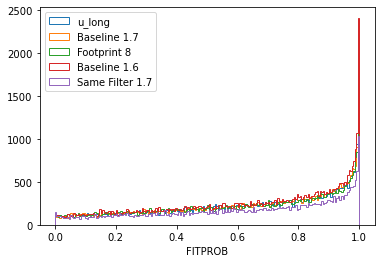

In [19]:
n, bins, patch = plt.hist(ulong_Merged['FITPROB'], label='u_long', histtype='step', bins = np.arange(0,1.005,0.005))
plt.hist(baseline1pt7_merged['FITPROB'], label='Baseline 1.7', histtype='step', bins = bins)
plt.hist(footprint8_Merged['FITPROB'], label='Footprint 8', histtype='step', bins = bins)
plt.hist(baseline1pt6_Merged['FITPROB'], label='Baseline 1.6', histtype='step', bins = bins)
plt.hist(sameflt1pt7_Merged['FITPROB'], label='Same Filter 1.7', histtype='step', bins = bins)

plt.xlabel(r'FITPROB')
plt.legend(loc='upper left')
plt.savefig('FITPROB_dist.pdf', bbox_inches='tight', dpi=300)

In [20]:
ulong_Merged.columns


Index(['snid', 'ra', 'dec', 'trigstart', 'trigend', 'days', 'sntype',
       'redshift', 'ob_first_tile_id', 'mjd_obs', 'qmost_ra', 'qmost_dec',
       'total_texp', 'q3c_dist', 'VARNAMES:', 'CID', 'IDSURVEY', 'TYPE',
       'FIELD', 'CUTFLAG_SNANA', 'zHEL', 'zHELERR', 'zCMB', 'zCMBERR', 'zHD',
       'zHDERR', 'VPEC', 'VPECERR', 'MWEBV', 'HOST_LOGMASS',
       'HOST_LOGMASS_ERR', 'HOST_sSFR', 'HOST_sSFR_ERR', 'PKMJDINI', 'SNRMAX1',
       'SNRMAX2', 'SNRMAX3', 'PKMJD', 'PKMJDERR', 'x1', 'x1ERR', 'c', 'cERR',
       'mB', 'mBERR', 'x0', 'x0ERR', 'COV_x1_c', 'COV_x1_x0', 'COV_c_x0',
       'NDOF', 'FITCHI2', 'FITPROB', 'SIM_TYPE_INDEX', 'SIM_TEMPLATE_INDEX',
       'SIM_LIBID', 'SIM_NGEN_LIBID', 'SIM_ZCMB', 'SIM_ZFLAG', 'SIM_VPEC',
       'SIM_DLMAG', 'SIM_PKMJD', 'SIM_x1', 'SIM_c', 'SIM_alpha', 'SIM_beta',
       'SIM_gammaDM', 'SIM_x0', 'SIM_mB', 'SIM_AV', 'SIM_RV', 'mu', 'muERR',
       'sim_mu'],
      dtype='object')

# Cadence Note Plots

In [21]:
husl = sns.hls_palette(6)
#husl_darker = sns.husl_palette(10, l=.5)

fig_width_pt = 246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = 4. #fig_width_pt*inches_per_pt  # width in inches
fig_height = 3.5      # height in inches
fig_size =  [fig_width,fig_height]
sns.set(context="paper", style="ticks",rc={'text.usetex': True,'figure.figsize': fig_size, 'font.family': [u'serif'], 'font.serif':[u'Computer Modern'],\
 'axes.linewidth': 0.5, 'xtick.major.width': 0.5,'ytick.major.width': 0.5,"xtick.direction": "in","ytick.direction": "in", "axes.axisbelow": False})


## Comparison to Baseline 1.7

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


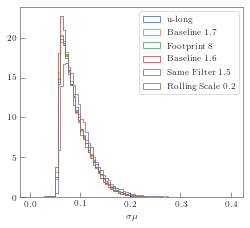

In [22]:
n, bins, patch = plt.hist(ulong_Merged['muERR'], label=r'u-long', histtype='step', bins = np.arange(0,0.41,0.005), density=True)
plt.hist(baseline1pt7_merged['muERR'], label=r'Baseline 1.7', histtype='step', bins = bins, density=True)
plt.hist(footprint8_Merged['muERR'], label=r'Footprint 8', histtype='step', bins = bins, density=True)
plt.hist(baseline1pt6_Merged['muERR'], label=r'Baseline 1.6', histtype='step', bins = bins, density=True)
plt.hist(sameflt1pt7_Merged['muERR'], label=r'Same Filter 1.5', histtype='step', bins = bins, density=True)
plt.hist(rolling02_Merged['muERR'], label=r'Rolling Scale 0.2', histtype='step', bins = bins, density=True)

plt.xlabel(r'$\sigma\mu$')
plt.legend()
plt.savefig('muERR_dist.pdf', bbox_inches='tight', dpi=300)

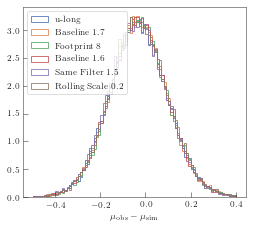

In [23]:
n, bins, patch = plt.hist(ulong_Merged['mu']-ulong_Merged['sim_mu'], label=r'u-long', histtype='step', bins = np.arange(-0.5,0.41,0.01), density=True)
plt.hist(baseline1pt7_merged['mu']-baseline1pt7_merged['sim_mu'], label=r'Baseline 1.7', histtype='step', bins = bins, density=True)
plt.hist(footprint8_Merged['mu']-footprint8_Merged['sim_mu'], label=r'Footprint 8', histtype='step', bins = bins, density=True)
plt.hist(baseline1pt6_Merged['mu']-baseline1pt6_Merged['sim_mu'], label=r'Baseline 1.6', histtype='step', bins = bins, density=True)
plt.hist(sameflt1pt7_Merged['mu']-sameflt1pt7_Merged['sim_mu'], label=r'Same Filter 1.5', histtype='step', bins = bins, density=True)
plt.hist(rolling02_Merged['mu']-rolling02_Merged['sim_mu'], label=r'Rolling Scale 0.2', histtype='step', bins = bins, density=True)

plt.xlabel(r'$\mu_{\mathrm{obs}} - \mu_{\mathrm{sim}}$')
plt.legend(loc='upper left')
plt.savefig('mu_simmu_dist.pdf', bbox_inches='tight', dpi=300)

# objects in all catalogues

In [24]:
print('Len baseline 1.6: ', len(baseline1pt6_Merged))
print('Len baseline 1.7: ', len(baseline1pt7_merged))
combined_df= pd.merge(baseline1pt7_merged, sameflt1pt7_Merged, on='snid', how='inner')
print('Length After bl1pt7 and 1pt6: ', len(combined_df))
combined_df = pd.merge(combined_df, footprint8_Merged, on='snid', how='inner')
print('Length After merge footprint 8: ', len(combined_df))
combined_df = pd.merge(combined_df, rolling02_Merged, on='snid', how='inner')
print('Length After merge rollingscale: ', len(combined_df))
#combined_df = pd.merge(combined_df, ulong_Merged, on='snid', how='inner')
#print('Length After merge ulong: ', len(combined_df))

Len baseline 1.6:  50346
Len baseline 1.7:  46547
Length After bl1pt7 and 1pt6:  2086
Length After merge footprint 8:  184
Length After merge rollingscale:  32


In [25]:
def plotLightCurve(snid,database,ax, trigActive=None, specTaken=None):
    query ='''select mjd, flt, fluxcal, fluxcalerr, zpt 
    from %s 
    where snid=%s and fluxcal/fluxcalerr>=3 
    order by mjd asc'''%(str(database)+'_sn_phot', str(snid))
    data_lc = pd.read_sql(query, conn)
    for bands in ['g','r','i','z']:
        idx = data_lc['flt']==bands
        ax.errorbar(data_lc['mjd'][idx], data_lc['fluxcal'][idx],\
                     yerr=data_lc['fluxcalerr'][idx], c=mat_c[bands],\
                     label=bands, fmt='.')
    if trigActive is not None:
        plt.axvline(trigActive, ls='--', c='k', lw=1, label='Triggered')
    #plt.axvline(row['trigend'], ls='--', c='k', lw=1)
    #plt.axhline(10**(-0.4*(22.5 - 27.5)), ls=':', c='red', lw=1, label='4MOST Depth')
    if specTaken is not None:
        plt.axvline(specTaken, ls='-.', c='blue', lw=2, label='Spec-Obs') 
    ax.legend(fontsize='small')
    ax.set_xlabel('MJD')
    ax.set_ylabel('Flux')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


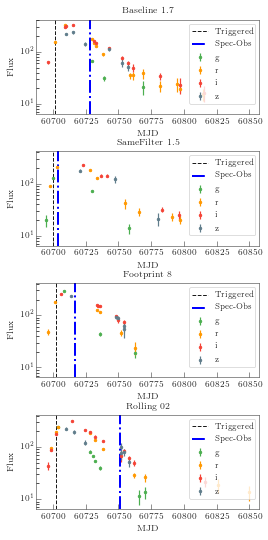

In [26]:
snid_in = np.unique(combined_df['snid'])[3]
plt.figure(figsize=(4,9))

ax = plt.subplot(4,1,1)
plotLightCurve(snid_in,'baseline_1pt7_wfd',ax,\
               trigActive=baseline1pt7_merged['trigstart'][baseline1pt7_merged['snid']==snid_in].iloc[0],\
              specTaken=baseline1pt7_merged['mjd_obs'][baseline1pt7_merged['snid']==snid_in].iloc[0])
ax.set_title('Baseline 1.7')
ax2 = plt.subplot(4,1,2,sharex=ax, sharey=ax)
plotLightCurve(snid_in,'sameflt15_1pt7_wfd',ax2,\
              trigActive=sameflt1pt7_Merged['trigstart'][sameflt1pt7_Merged['snid']==snid_in].iloc[0],\
              specTaken=sameflt1pt7_Merged['mjd_obs'][sameflt1pt7_Merged['snid']==snid_in].iloc[0])
ax2.set_title('SameFilter 1.5')
ax3 = plt.subplot(4,1,3,sharex=ax, sharey=ax)
plotLightCurve(snid_in,'footprint8_1pt7_wfd',ax3,\
              trigActive=footprint8_Merged['trigstart'][footprint8_Merged['snid']==snid_in].iloc[0],\
              specTaken=footprint8_Merged['mjd_obs'][footprint8_Merged['snid']==snid_in].iloc[0])
ax3.set_title('Footprint 8')

ax4 = plt.subplot(4,1,4,sharex=ax, sharey=ax)
plotLightCurve(snid_in,'rollingscale02_1pt7_wfd',ax4,\
              trigActive=rolling02_Merged['trigstart'][rolling02_Merged['snid']==snid_in].iloc[0],\
              specTaken=rolling02_Merged['mjd_obs'][rolling02_Merged['snid']==snid_in].iloc[0])
ax4.set_title('Rolling 02')

ax.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax4.set_yscale('log')
plt.subplots_adjust(hspace=0.4)
plt.savefig('./LightcurveMatchCompare.pdf', bbox_inches='tight')

# Phase for Data Acqusition

Let's do this in the rest-frame. Query the databasse for the model peak dates and then plot up the phase for spectra actisition and triggering

In [27]:
def getSNheadInfo(database,df_in):
    queryHead ='''select snid, redshift_final, sim_peakmjd, nobs from
    %s 
    where snid in (%s)'''%(str(database)+'_sn_head',', '.join(map(str,list(np.unique(df_in['snid'])))))
    data_Head = pd.read_sql(queryHead, conn)
    data_Head['snid'] = data_Head['snid'].astype(np.int64)
    mergedHead = df_in.merge(data_Head, how='inner', left_on='snid', right_on='snid',\
                             suffixes=(False, False), copy=True)
    mergedHead['specphase_rest'] = (mergedHead['mjd_obs'] - mergedHead['sim_peakmjd'])/(1+mergedHead['redshift_final'])
    mergedHead['trigphase_rest'] = (mergedHead['trigstart'] - mergedHead['sim_peakmjd'])/(1+mergedHead['redshift_final'])
    return mergedHead

In [73]:
baseline1pt7_snhead = getSNheadInfo('baseline_1pt7_wfd', baseline1pt7_merged)
ulong_snhead = getSNheadInfo('u_long_1pt7_wfd', ulong_Merged)
footprint8_snhead = getSNheadInfo('footprint8_1pt7_wfd', footprint8_Merged)
sameflt_snhead = getSNheadInfo('sameflt15_1pt7_wfd', sameflt1pt7_Merged)
rolling02_snhead = getSNheadInfo('rollingscale02_1pt7_wfd', rolling02_Merged)
baseline1pt6_snhead = getSNheadInfo('baseline16_1pt7_wfd', baseline1pt6_Merged)
rolling1_snhead = getSNheadInfo('rollingscale1_1pt7_wfd', rolling1_Merged)

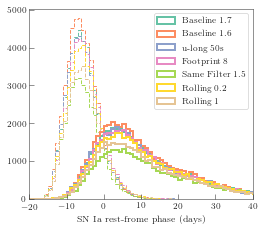

In [75]:
_ =plt.hist(baseline1pt7_snhead['trigphase_rest'], histtype='step', bins=np.arange(-20,100,1), ls='--', color='#66c2a5', lw=1)
_ =plt.hist(baseline1pt6_snhead['trigphase_rest'], histtype='step', bins=np.arange(-20,100,1), ls='--', color='#fc8d62', lw=1)
_ =plt.hist(ulong_snhead['trigphase_rest'], histtype='step', bins=np.arange(-20,100,1), ls='--', color='#8da0cb', lw=1)
_ =plt.hist(footprint8_snhead['trigphase_rest'], histtype='step', bins=np.arange(-20,100,1), ls='--', color='#e78ac3', lw=1)
_ =plt.hist(sameflt_snhead['trigphase_rest'], histtype='step', bins=np.arange(-20,100,1), ls='--',color='#a6d854', lw=1)
_ =plt.hist(rolling02_snhead['trigphase_rest'], histtype='step', bins=np.arange(-20,100,1), ls='--',color='#ffd92f', lw=1)
_ =plt.hist(rolling1_snhead['trigphase_rest'], histtype='step', bins=np.arange(-20,100,1), ls='--',color='#e5c494', lw=1)

_ =plt.hist(baseline1pt7_snhead['specphase_rest'], histtype='step', bins=np.arange(-20,100,1), label='Baseline 1.7', color='#66c2a5', lw=2)
_ =plt.hist(baseline1pt6_snhead['specphase_rest'], histtype='step', bins=np.arange(-20,100,1), label='Baseline 1.6', color='#fc8d62', lw=2)
_ =plt.hist(ulong_snhead['specphase_rest'], histtype='step', bins=np.arange(-20,100,1), label='u-long 50s', color='#8da0cb', lw=2)
_ =plt.hist(footprint8_snhead['specphase_rest'], histtype='step', bins=np.arange(-20,100,1), label='Footprint 8', color='#e78ac3', lw=2)
_ =plt.hist(sameflt_snhead['specphase_rest'], histtype='step', bins=np.arange(-20,100,1), label='Same Filter 1.5',color='#a6d854', lw=2)
_ =plt.hist(rolling02_snhead['specphase_rest'], histtype='step', bins=np.arange(-20,100,1), label='Rolling 0.2 ',color='#ffd92f', lw=2)
_ =plt.hist(rolling1_snhead['specphase_rest'], histtype='step', bins=np.arange(-20,100,1), label='Rolling 1',color='#e5c494', lw=2)

plt.xlim(-20,40)
#plt.yscale('log')
plt.legend()
#386cb0
plt.xlabel('SN Ia rest-frome phase (days)')
plt.savefig('./specPhaseTrig.pdf', bbox_inches='tight')

In [84]:
in_arr = [baseline1pt7_snhead, baseline1pt6_snhead, ulong_snhead, footprint8_snhead, rolling02_snhead, rolling1_snhead, sameflt_snhead]
trig_arr = []

for i in range(len(in_arr)):
    trig_arr.append( 100*(np.mean(in_arr[i]['trigphase_rest'])-np.mean(baseline1pt7_snhead['trigphase_rest']))/np.mean(baseline1pt7_snhead['trigphase_rest']))

print(trig_arr)

[-0.0, 2.8110544920206104, 0.962614130185793, -7.48784227220592, -5.5689668047507395, -7.472277839325383, 1.0500863897131518]


In [81]:
(ulong_snhead['trigphase_rest']-baseline1pt7_snhead['trigphase_rest'])/(baseline1pt7_snhead['trigphase_rest'])

0       -1.052632
1       -0.843201
2       -7.440511
3       -0.742682
4        2.147207
           ...   
46542         NaN
46543         NaN
46544         NaN
46545         NaN
46546         NaN
Name: trigphase_rest, Length: 46547, dtype: float64

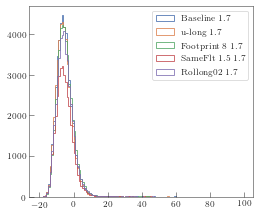

In [32]:
_ =plt.hist(baseline1pt7_snhead['trigphase_rest'], histtype='step', bins=np.arange(-20,100,1), label='Baseline 1.7')
_ =plt.hist(ulong_snhead['trigphase_rest'], histtype='step', bins=np.arange(-20,100,1), label='u-long 1.7')
_ =plt.hist(footprint8_snhead['trigphase_rest'], histtype='step', bins=np.arange(-20,100,1), label='Footprint 8 1.7')
_ =plt.hist(sameflt_snhead['trigphase_rest'], histtype='step', bins=np.arange(-20,100,1), label='SameFlt 1.5 1.7')
_ =plt.hist(rolling02_snhead['trigphase_rest'], histtype='step', bins=np.arange(-20,100,1), label='Rollong02 1.7')
plt.legend()

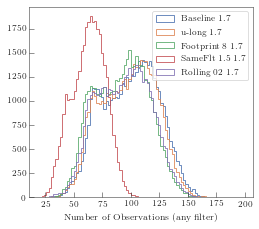

In [35]:
n, bins, pat =plt.hist(baseline1pt7_snhead['nobs'], histtype='step', bins=np.arange(20,200,2), label='Baseline 1.7')
_ =plt.hist(ulong_snhead['nobs'], histtype='step', bins=bins, label='u-long 1.7')
_ =plt.hist(footprint8_snhead['nobs'], histtype='step', bins=bins, label='Footprint 8 1.7')
_ =plt.hist(sameflt_snhead['nobs'], histtype='step', bins=bins, label='SameFlt 1.5 1.7')
_ =plt.hist(rolling02_snhead['nobs'], histtype='step', bins=bins, label='Rolling 02 1.7')
plt.legend()
plt.xlabel('Number of Observations (any filter)')
plt.savefig('Nobs.pdf', bbox_inches='tight')

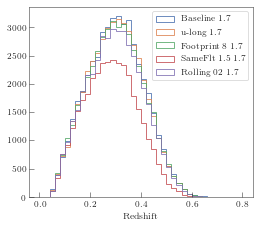

In [36]:
n, bins, pat =plt.hist(baseline1pt7_snhead['zHD'], histtype='step', bins=np.arange(0,0.82,0.02), label='Baseline 1.7')
_ =plt.hist(ulong_snhead['zHD'], histtype='step', bins=bins, label='u-long 50ms')
_ =plt.hist(footprint8_snhead['zHD'], histtype='step', bins=bins, label='Footprint 8')
_ =plt.hist(sameflt_snhead['zHD'], histtype='step', bins=bins, label='SameFlt 1.5')
_ =plt.hist(rolling02_snhead['zHD'], histtype='step', bins=bins, label='Rolling 0.2')
plt.legend()
plt.xlabel('Redshift')
plt.savefig('redshift.pdf', bbox_inches='tight')

In [37]:
!which python

/home/cf5g09/anaconda3/envs/tides/bin/python


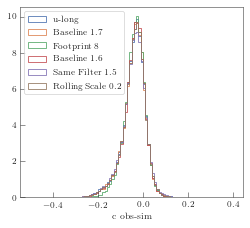

In [44]:

n, bins, patch = plt.hist(ulong_Merged['c']-ulong_Merged['SIM_c'], label=r'u-long', histtype='step', bins = np.arange(-0.5,0.41,0.01), density=True)
plt.hist(baseline1pt7_merged['c']-baseline1pt7_merged['SIM_c'], label=r'Baseline 1.7', histtype='step', bins = bins, density=True)
plt.hist(footprint8_Merged['c']-footprint8_Merged['SIM_c'], label=r'Footprint 8', histtype='step', bins = bins, density=True)
plt.hist(baseline1pt6_Merged['c']-baseline1pt6_Merged['SIM_c'], label=r'Baseline 1.6', histtype='step', bins = bins, density=True)
plt.hist(sameflt1pt7_Merged['c']-sameflt1pt7_Merged['SIM_c'], label=r'Same Filter 1.5', histtype='step', bins = bins, density=True)
plt.hist(rolling02_Merged['c']-rolling02_Merged['SIM_c'], label=r'Rolling Scale 0.2', histtype='step', bins = bins, density=True)

plt.xlabel('c obs-sim')
plt.legend(loc='upper left')
plt.savefig('c_simc_dist.pdf', bbox_inches='tight', dpi=300)

In [45]:
!pwd

/data/cf5g09/tides/paperSims2021/cadenceNote


In [46]:
ulong_Merged.columns

Index(['snid', 'ra', 'dec', 'trigstart', 'trigend', 'days', 'sntype',
       'redshift', 'ob_first_tile_id', 'mjd_obs', 'qmost_ra', 'qmost_dec',
       'total_texp', 'q3c_dist', 'VARNAMES:', 'CID', 'IDSURVEY', 'TYPE',
       'FIELD', 'CUTFLAG_SNANA', 'zHEL', 'zHELERR', 'zCMB', 'zCMBERR', 'zHD',
       'zHDERR', 'VPEC', 'VPECERR', 'MWEBV', 'HOST_LOGMASS',
       'HOST_LOGMASS_ERR', 'HOST_sSFR', 'HOST_sSFR_ERR', 'PKMJDINI', 'SNRMAX1',
       'SNRMAX2', 'SNRMAX3', 'PKMJD', 'PKMJDERR', 'x1', 'x1ERR', 'c', 'cERR',
       'mB', 'mBERR', 'x0', 'x0ERR', 'COV_x1_c', 'COV_x1_x0', 'COV_c_x0',
       'NDOF', 'FITCHI2', 'FITPROB', 'SIM_TYPE_INDEX', 'SIM_TEMPLATE_INDEX',
       'SIM_LIBID', 'SIM_NGEN_LIBID', 'SIM_ZCMB', 'SIM_ZFLAG', 'SIM_VPEC',
       'SIM_DLMAG', 'SIM_PKMJD', 'SIM_x1', 'SIM_c', 'SIM_alpha', 'SIM_beta',
       'SIM_gammaDM', 'SIM_x0', 'SIM_mB', 'SIM_AV', 'SIM_RV', 'mu', 'muERR',
       'sim_mu'],
      dtype='object')

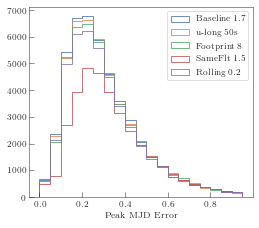

In [53]:
n, bins, pat =plt.hist(baseline1pt7_snhead['PKMJDERR'], histtype='step', bins=np.arange(0,1,0.05), label='Baseline 1.7')
_ =plt.hist(ulong_snhead['PKMJDERR'], histtype='step', bins=bins, label='u-long 50s')
_ =plt.hist(footprint8_snhead['PKMJDERR'], histtype='step', bins=bins, label='Footprint 8')
_ =plt.hist(sameflt_snhead['PKMJDERR'], histtype='step', bins=bins, label='SameFlt 1.5')
_ =plt.hist(rolling02_snhead['PKMJDERR'], histtype='step', bins=bins, label='Rolling 0.2')
plt.legend()
plt.xlabel('Peak MJD Error')
plt.savefig('peakMJDERR.pdf', bbox_inches='tight')

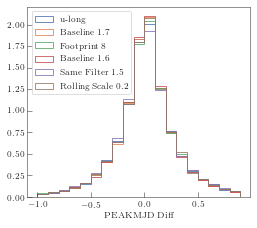

In [52]:
n, bins, patch = plt.hist(ulong_Merged['PKMJD']-ulong_Merged['SIM_PKMJD'], label=r'u-long', histtype='step', bins = np.arange(-1,1,0.1), density=True)
plt.hist(baseline1pt7_merged['PKMJD']-baseline1pt7_merged['SIM_PKMJD'], label=r'Baseline 1.7', histtype='step', bins = bins, density=True)
plt.hist(footprint8_Merged['PKMJD']-footprint8_Merged['SIM_PKMJD'], label=r'Footprint 8', histtype='step', bins = bins, density=True)
plt.hist(baseline1pt6_Merged['PKMJD']-baseline1pt6_Merged['SIM_PKMJD'], label=r'Baseline 1.6', histtype='step', bins = bins, density=True)
plt.hist(sameflt1pt7_Merged['PKMJD']-sameflt1pt7_Merged['SIM_PKMJD'], label=r'Same Filter 1.5', histtype='step', bins = bins, density=True)
plt.hist(rolling02_Merged['PKMJD']-rolling02_Merged['SIM_PKMJD'], label=r'Rolling Scale 0.2', histtype='step', bins = bins, density=True)

plt.xlabel('PEAKMJD Diff')
plt.legend(loc='upper left')
plt.savefig('peakmjd_diff_dist.pdf', bbox_inches='tight', dpi=300)

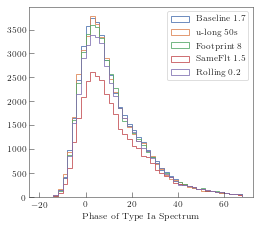

In [94]:
(baseline1pt7_merged['mjd_obs'] - baseline1pt7_merged['PKMJD'])/(1+baseline1pt7_merged['redshift'])

n, bins, pat =plt.hist((baseline1pt7_merged['mjd_obs'] - baseline1pt7_merged['PKMJD'])/(1+baseline1pt7_merged['redshift']), histtype='step', bins=np.arange(-20,70,2), label='Baseline 1.7')
_ =plt.hist((ulong_snhead['mjd_obs'] - ulong_snhead['PKMJD'])/(1+ulong_snhead['redshift']), histtype='step', bins=bins, label='u-long 50s')
_ =plt.hist((footprint8_snhead['mjd_obs'] - footprint8_snhead['PKMJD'])/(1+footprint8_snhead['redshift']), histtype='step', bins=bins, label='Footprint 8')
_ =plt.hist((sameflt_snhead['mjd_obs'] - sameflt_snhead['PKMJD'])/(1+sameflt_snhead['redshift']), histtype='step', bins=bins, label='SameFlt 1.5')
_ =plt.hist((rolling02_snhead['mjd_obs'] - rolling02_snhead['PKMJD'])/(1+rolling02_snhead['redshift']), histtype='step', bins=bins, label='Rolling 0.2')
plt.legend()
plt.xlabel('Phase of Type Ia Spectrum')
plt.savefig('spectrumPhase.png', bbox_inches='tight', dpi=300)


In [89]:
baseline1pt7_merged.columns

Index(['snid', 'ra', 'dec', 'trigstart', 'trigend', 'days', 'sntype',
       'redshift', 'ob_first_tile_id', 'mjd_obs', 'qmost_ra', 'qmost_dec',
       'total_texp', 'q3c_dist', 'VARNAMES:', 'CID', 'IDSURVEY', 'TYPE',
       'FIELD', 'CUTFLAG_SNANA', 'zHEL', 'zHELERR', 'zCMB', 'zCMBERR', 'zHD',
       'zHDERR', 'VPEC', 'VPECERR', 'MWEBV', 'HOST_LOGMASS',
       'HOST_LOGMASS_ERR', 'HOST_sSFR', 'HOST_sSFR_ERR', 'PKMJDINI', 'SNRMAX1',
       'SNRMAX2', 'SNRMAX3', 'PKMJD', 'PKMJDERR', 'x1', 'x1ERR', 'c', 'cERR',
       'mB', 'mBERR', 'x0', 'x0ERR', 'COV_x1_c', 'COV_x1_x0', 'COV_c_x0',
       'NDOF', 'FITCHI2', 'FITPROB', 'SIM_TYPE_INDEX', 'SIM_TEMPLATE_INDEX',
       'SIM_LIBID', 'SIM_NGEN_LIBID', 'SIM_ZCMB', 'SIM_ZFLAG', 'SIM_VPEC',
       'SIM_DLMAG', 'SIM_PKMJD', 'SIM_x1', 'SIM_c', 'SIM_alpha', 'SIM_beta',
       'SIM_gammaDM', 'SIM_x0', 'SIM_mB', 'SIM_AV', 'SIM_RV', 'mu', 'muERR',
       'sim_mu'],
      dtype='object')